Example code for Menemenlis et al. (2022). A proxy-model comparison for mid-Pliocene warm period hydroclimate in the Southwestern US. Earth and Planetary Science Letters 596, 117803. https://doi.org/10.1016/j.epsl.2022.117803. 

Adapted from Ibarra et al. 2018. Warm and cold wet states in the western United States during the Pliocene–Pleistocene. Geology 46, 355–358. https://doi.org/10.1130/G39962.1. 

Data: 
- All figures use reanalysis data from MERRA2 (available at disc.gsfc.nasa.gov). 
- Figures 2 and 3 require a GIS shapefile of a group of endorheic basins. 

Contact: Sofia Menemenlis, smenemenlis@princeton.edu


In [ ]:
%pylab inline

import numpy as np
import math
import random
import time
import glob

from netCDF4 import Dataset as ncopen
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, Point
import regionmask
from scipy import interpolate

import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import matplotlib.patches as patches
from matplotlib.patches import Rectangle

import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature


In [2]:
def load_reanalysis(): 
    
    '''Function to load MERRA2 reanalysis data (Gelaro et al., 2017), available at disc.gsfc.nasa.gov'''

    data_dir = '/gpfs/gibbs/pi/lora/menemenlis/MERRA2/'

    # how many years of reanalysis? 
    years_data = 41

    # interpolate to this uniform grid. 
    lon1 = arange(-180,180,.25); lat1 = arange(-89.75,90,.25)  

    df = ncopen(data_dir+'MERRA2_101.const_2d_asm_Nx.00000000.nc4','r')
    lon = df['lon'][:]
    lat = df['lat'][:]
    f = interpolate.interp2d(lon,lat,df['FRLAND'][:],kind='linear')
    frland=f(lon1,lat1)           # fraction of land       
    f = interpolate.interp2d(lon,lat,df['PHIS'][:],kind='linear')
    elev=f(lon1,lat1)/9.8         # geopotential to geopotential height
    df.close()
    print('loaded land fraction and topography')

    files_list = sorted(glob.glob(data_dir+'MERRA2_*tavgU_2d_flx_Nx*'))
    prate_mon = zeros(shape=(size(files_list),size(lat1),size(lon1)))
    for i,f in enumerate(files_list): 
        df = ncopen(f,'r')
        pr = df['PRECTOTCORR'][:]  # precipitation
        f = interpolate.interp2d(lon,lat,np.mean(pr,axis=0),kind='linear')
        prate_mon[i] = f(lon1,lat1)*86400*30.4375 # from kg m-2 s-1 to mm/mon
        df.close()
    print('loaded precip')

    files_list = sorted(glob.glob(data_dir+'MERRA2_*tavgU_2d_rad_Nx*'))
    skintemp_mon = zeros(shape=(size(files_list),size(lat1),size(lon1)))
    pet_mon = zeros(shape=(size(files_list),size(lat1),size(lon1)))
    for i,f in enumerate(files_list): 
        df = ncopen(f,'r')
        ts = df['TS'][:]           # skin temperature in K
        f = interpolate.interp2d(lon,lat,np.mean(ts,axis=0),kind='linear')
        skintemp_mon[i] = f(lon1,lat1)
        # use net radiation to calculate potential evapotranspiration: 
        sw = df['SWGNT'][:]
        lw = df['LWGNT'][:]
        f = interpolate.interp2d(lon,lat,np.mean(lw+sw,axis=0),kind='linear')
        pet_mon[i] = f(lon1,lat1)*((86400*30.4375)/(2264.76*1000))  # from W/m2 to mm/mon
        df.close()
    print('loaded radiation and temperature')
    
    return lon1, lat1, years_data, frland, elev, prate_mon, skintemp_mon, pet_mon
    

## Example code for Figure 1: 

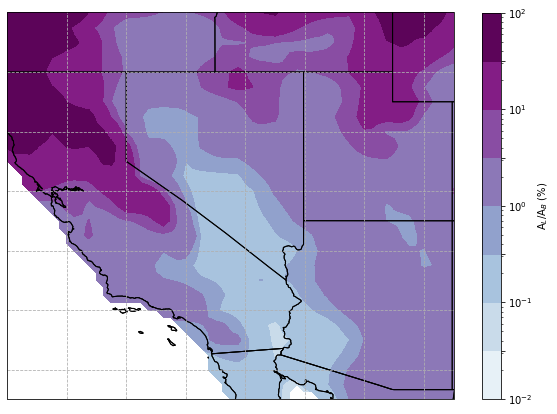

In [16]:
# Estimated lake areas by grid cell

lon1, lat1, years_data, frland, elev, prate_mon, skintemp_mon, pet_mon = load_reanalysis()

# mask with just the land-sea mask
MERRA2_mask = np.where(frland<0.2,True,False)   # mask if < 20% of a grid cell is land (can adjust this fraction)
MERRA2_mask = np.squeeze(MERRA2_mask)
            
# sum precip, pet, temperature data. 
precip_sum = np.sum(prate_mon,axis=0)
precip_sum = np.ma.masked_array(precip_sum,MERRA2_mask)
pet_sum = np.sum(pet_mon,axis=0)
pet_sum = np.ma.masked_array(pet_sum,MERRA2_mask)
temp_mean = np.mean(skintemp_mon,axis=0)
temp_mean = np.ma.masked_array(temp_mean,MERRA2_mask)

# calculate slope of temperature-dependent saturation vapor pressure curve. Get delta for Priestly-Taylor equation. 
def s(temp): 
    return 4098*(0.6108*exp(17.27*temp/(temp+237.3)))/(temp+237.3)**2 # in kPa/K
delta_cont = s(temp_mean-273.15)

#psychrometric constant [kPa/K] function 
def psychro(elev):
    press = 101.3*((293-0.0065*elev)/293)**5.26
    return 0.665e-3*press
psychro_cont = squeeze(psychro(elev))

# Budyko omega parameter
w = 2.6 
# Priestley-Taylor constant. 
alpha = 1.26

# Calculate "modern" lake area. 
k_run_mod = ((pet_sum/precip_sum) - (1 + (pet_sum/precip_sum)**w)**(1/w))*(-1) 
mod_lake_evap = alpha*(delta_cont/(delta_cont+psychro_cont))*pet_sum
mod_lake_areas = 100*((precip_sum*k_run_mod)/(mod_lake_evap - precip_sum + (precip_sum*k_run_mod)))

# Set overflow values to 100. 
mod_lake_areas = ma.where((mod_lake_areas<0),100,mod_lake_areas)
mod_lake_areas = ma.where((mod_lake_areas>100),100,mod_lake_areas)

# Plot. 

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
fill = plt.contourf(lon1, lat1, mod_lake_areas,
                    np.array([10e-3,.05,10e-2,.5,10e-1,5,10e0,50,10e1]),             
                    locator=ticker.LogLocator(),
                    cmap = 'BuPu',
                   transform = ccrs.PlateCarree())
ax.set_extent([236,251,31,44])   # zoom in slightly

ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.STATES)

plt.colorbar(shrink=0.71, label='A$_L$/A$_B$ (%)')

gl0 = ax.gridlines(axes=ax,crs=ccrs.PlateCarree(),draw_labels = True,linestyle='--')
gl0.top_labels=False
gl0.right_labels=False
gl0.left_labels=True
gl0.bottom_labels=True
gl0.xformatter = LONGITUDE_FORMATTER
gl0.yformatter = LATITUDE_FORMATTER
plt.show()


## Example code for Figures 2, 3: 

In [19]:
lon1, lat1, years_data, frland, elev, prate_mon, skintemp_mon, pet_mon = load_reanalysis()

# load in shapefile of region
region = 'SouthGB4.1'
region_gdf = gpd.read_file('/home/sam284/plio_proxies/ShapeFiles/ShapeFile_'+region+'/'+region+'.shp') # Geopandas GeoDataFrame
MERRA2_mask = np.invert(np.squeeze(regionmask.mask_3D_geopandas(region_gdf, lon1, lat1)))
            
precip_sum = np.sum(prate_mon,axis=0)
precip_sum = np.ma.masked_array(precip_sum,MERRA2_mask)
pet_sum = np.sum(pet_mon,axis=0)
pet_sum = np.ma.masked_array(pet_sum,MERRA2_mask)
temp_mean = np.mean(skintemp_mon,axis=0)
temp_mean = np.ma.masked_array(temp_mean,MERRA2_mask)

# calculate slope of saturation vapor pressure (temperature dependent). get delta for Priestly-Taylor equation
def s(temp): 
    return 4098*(0.6108*exp(17.27*temp/(temp+237.3)))/(temp+237.3)**2 # in kPa/K
delta_cont = s(temp_mean-273.15)

#psychrometric constant [kPa/K] function 
def psychro(elev):
    press = 101.3*((293-0.0065*elev)/293)**5.26
    return 0.665e-3*press
psychro_cont = squeeze(psychro(elev))


def slake_area(dP,dT,RNvT,PETvT,w,alpha): 
    '''Calculates the estimated total lake area percentage; equation 3 terms are summed over entire region.
    dP = change in precipitation rate from modern
    RNvT = fractional change in net radiation with temperature
    PETvT = fractional change in potential evapotranspiration with temperature 
    w = Budyko parameter (omega)
    alpha = Priestley-Taylor constant
    '''
    # Calculate Krun values. what fraction of P is converted to runoff? 
    k_run_mod = ((pet_sum/precip_sum) - (1 + (pet_sum/precip_sum)**w)**(1/w))*(-1) 
    # Calculate lake evaporation
    mod_lake_evap = alpha*(delta_cont/(delta_cont+psychro_cont))*pet_sum
    # initial values
    mod_lake_areas = 100*((precip_sum*k_run_mod)/(mod_lake_evap - precip_sum + (precip_sum*k_run_mod)))
    # Total sum of the precipitation difference. 
    dP_sum = dP*365.25*years_data
    # Scale PET with surface temperature
    pet_sum1 = pet_sum + pet_sum*(PETvT*dT) 
    # Scale RN with surface temperature
    pet_sum1_RNscaled = pet_sum + pet_sum*(RNvT*dT)
    # Calculate new runoff using new PET
    k_run1 = ((pet_sum1/(precip_sum+dP_sum)) - (1 + (pet_sum1/(precip_sum+dP_sum))**w)**(1/w))*(-1)
    # Calculate new lake evaporation using new RN
    lake_evap1 = alpha*(s(temp_mean-273.15+dT)/(s(temp_mean-273.15+dT)+psychro_cont))*pet_sum1_RNscaled
    # Sum terms to use in equation 3: 
    sPkrun = np.sum((precip_sum+dP_sum)*k_run1)
    sE = np.sum(lake_evap1)
    sP = np.sum((precip_sum+dP_sum))
    # Apply equation 3: 
    slake_area1 = (sPkrun/(sE-sP+sPkrun))*100
    return slake_area1

# e.g., for standard parameters with no change against modern, find the lake area percentage: 
slake_area(dP=0,dT=0,RNvT=.016,PETvT=0.025,w=2.6,alpha=1.26)


1.038090090209323

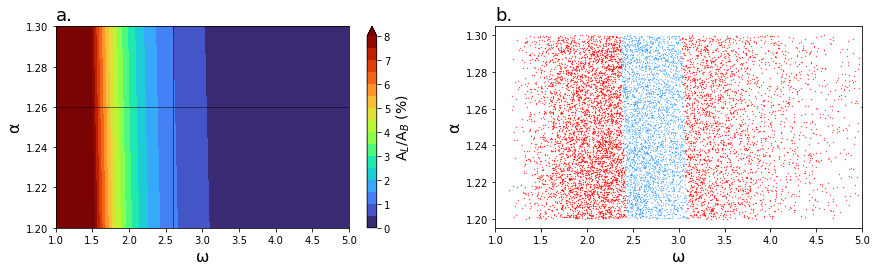

In [29]:
# Figure 2: 

lower_bound = 0.5; upper_bound = 1.5
dT = 0; dP = 0
size_sample = 10**4

initial_omegas = []
initial_alphas = []
good_combos = []
reject_combos = []

areas = np.zeros(shape=(size_sample))
for i in range(size_sample): 
    RNvT = 0.016; PETvT = 0.02
    random_w = 1 + np.random.gamma(4.54,0.37)  # shape = 4.54, scale = 0.37
    initial_omegas.append(random_w)
    random_alpha = np.random.uniform(1.2,1.3)
    initial_alphas.append(random_alpha)
    area = slake_area(dP, dT, RNvT, PETvT, random_w, random_alpha)
    if area < lower_bound or area > upper_bound: 
        reject_combos.append((random_w,random_alpha))
    else: 
        good_combos.append((random_w,random_alpha))
    areas[i] = area
    if (i%10)==0: 
        print(str((i/size_sample)*100.)+'% complete')
        
good_combos_arr = np.array(good_combos)
reject_combos_arr = np.array(reject_combos)
np.save('/home/sam284/plio_proxies/MERRA2_lake_modeling/good_combos_arr_10e4samples',good_combos_arr)
np.save('/home/sam284/plio_proxies/MERRA2_lake_modeling/reject_combos_arr_10e4samples',reject_combos_arr)

## if you have already saved out the data above: 
# good_combos_arr = np.load('/home/sam284/plio_proxies/MERRA2_lake_modeling/good_combos_arr_10e4samples.npy')
# good_combos = good_combos_arr.tolist()
# reject_combos_arr = np.load('/home/sam284/plio_proxies/MERRA2_lake_modeling/reject_combos_arr_10e4samples.npy')
# reject_combos = reject_combos_arr.tolist()

# plot sensitivity to alpha and omega
alphas = np.arange(1.2,1.305,0.005)
omegas = np.arange(1.0,5.1,0.1)
areas = zeros((len(alphas),len(omegas)))
RNvT = 0.016; PETvT = 0.02

for i in range(len(alphas)): 
    alpha = alphas[i]
    for j in range(len(omegas)): 
        w = omegas[j]
        dP = 0; dT = 0
        k_run_mod = ((pet_sum/precip_sum) - (1 + (pet_sum/precip_sum)**w)**(1/w))*(-1) 
        mod_lake_evap = alpha*(delta_cont/(delta_cont+psychro_cont))*pet_sum
        mod_lake_areas = 100*((precip_sum*k_run_mod)/(mod_lake_evap - precip_sum + (precip_sum*k_run_mod)))
        dP_sum = dP*365.25*years_data
        pet_sum1 = pet_sum + pet_sum*(PETvT*dT) 
        pet_sum1_RNscaled = pet_sum + pet_sum*(RNvT*dT)
        k_run1 = ((pet_sum1/(precip_sum+dP_sum)) - (1 + (pet_sum1/(precip_sum+dP_sum))**w)**(1/w))*(-1)    
        lake_evap1 = alpha*(s(temp_mean-273.15+dT)/(s(temp_mean-273.15+dT)+psychro_cont))*pet_sum1_RNscaled    
        sPkrun = np.sum((precip_sum+dP_sum)*k_run1)
        sE = np.sum(lake_evap1)
        sP = np.sum((precip_sum+dP_sum))
        slake_area1 = (sPkrun/(sE-sP+sPkrun))*100
        areas[i,j] = slake_area1
    print('approx. '+str((i+1)/len(alphas)*100)+' % done')
print('done!')

fig,axs = plt.subplots(figsize=(14,4))
c = 1

ax = plt.subplot(1,2,1)
plt.hlines(1.26,min(omegas),max(omegas),color='k',linewidth=0.5)
plt.vlines(2.6,min(alphas),max(alphas),color='k',linewidth=0.5)
a = plt.contourf(omegas,alphas,areas,arange(0,8.5,.5),cmap='turbo',extend='max')  # rainbow colormap was Turbo
cbar = plt.colorbar(a,orientation='vertical')
cbar.set_label(label='A$_L$/A$_B$ (%)',size=14)
plt.xlabel('ω',size=16)
plt.ylabel('α',size=16)
plt.title('a.',size=18,loc='left')

good_omegas,good_alphas = zip(*good_combos)
reject_omegas,reject_alphas = zip(*reject_combos)

ax = plt.subplot(1,2,2)
plt.scatter(good_omegas,good_alphas,color='dodgerblue',s=0.05)
plt.scatter(reject_omegas,reject_alphas,color='red',s=0.1)
ax.set_xlim(1,5)
plt.xlabel('ω',size=16)
plt.ylabel('α',size=16)
plt.title('b.',size=18,loc='left')

fig.subplots_adjust(bottom=0.2,top=0.9,left=0.1,right=0.9,
                   wspace=0.2, hspace=0.1)
plt.show()    


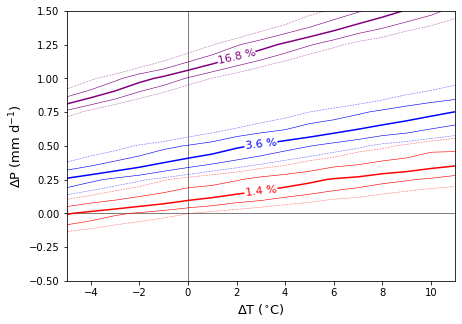

In [32]:
# Figure 3: 

temp_fac = np.arange(-5,12,1) # absolute changes
precip_fac = np.arange(-.5,1.75,.25)  # absolute changes 

size_sample=10**3

mean_space = zeros((len(precip_fac),len(temp_fac)))
q1_space   = zeros((len(precip_fac),len(temp_fac)))
q3_space   = zeros((len(precip_fac),len(temp_fac)))
p5_space   = zeros((len(precip_fac),len(temp_fac)))
p95_space  = zeros((len(precip_fac),len(temp_fac)))

for i in range(len(precip_fac)): 
    for j in range(len(temp_fac)):
        start = time.time()
        dP = precip_fac[i]
        dT = temp_fac[j]
        areas = np.zeros(shape=size_sample)
        for k in range(size_sample): 
            combo = good_combos[np.random.randint(0,len(good_combos))]  # generate a combo using a random index
            w, alpha = combo
            RNvT = np.random.uniform(0.009,0.016)
            PETvT = np.random.uniform(0.018,0.028)
            area = slake_area(dP,dT,RNvT,PETvT,w,alpha)
            if area < 0: 
                area = 100
            elif area > 100: 
                area=100
            areas[k] = area
        mean_space[i,j] = np.mean(areas)
        q1_space[i,j]  = np.percentile(areas,25)
        q3_space[i,j]  = np.percentile(areas,75)
        p5_space[i,j]  = np.percentile(areas,5)
        p95_space[i,j] = np.percentile(areas,95)
        end = time.time()
        print('i='+str(i)+', j='+str(j)+', time = '+str(end-start)+' s')
        
    print('approx. '+str((i+1)/len(precip_fac)*100)+' % done')
    
np.save('/home/sam284/plio_proxies/Figures/fine_grid_ss10e3_mean_space',mean_space)
np.save('/home/sam284/plio_proxies/Figures/fine_grid_ss10e3_q1_space',q1_space)
np.save('/home/sam284/plio_proxies/Figures/fine_grid_ss10e3_q3_space',q3_space)
np.save('/home/sam284/plio_proxies/Figures/fine_grid_ss10e3_p5_space',p5_space)
np.save('/home/sam284/plio_proxies/Figures/fine_grid_ss10e3_p95_space',p95_space)

## if you have already saved out the data above: 
# mean_space = np.load('/home/sam284/plio_proxies/Figures/fine_grid_ss10e3_mean_space.npy')
# q1_space = np.load('/home/sam284/plio_proxies/Figures/fine_grid_ss10e3_q1_space.npy')
# q3_space = np.load('/home/sam284/plio_proxies/Figures/fine_grid_ss10e3_q3_space.npy')
# p5_space = np.load('/home/sam284/plio_proxies/Figures/fine_grid_ss10e3_p5_space.npy')
# p95_space = np.load('/home/sam284/plio_proxies/Figures/fine_grid_ss10e3_p95_space.npy')

# percentages for scenarios 1, 2, and 3
sc1 = 1.4
sc2 = 3.6
sc3 = 16.8

fig, ax = plt.subplots(figsize=(9,5))

plt.hlines(0,min(temp_fac),max(temp_fac),linewidth=0.5,color='black')
plt.vlines(0,min(precip_fac),max(precip_fac),linewidth=0.5,color='black')
mean_contour = plt.contour(temp_fac,precip_fac,mean_space,[sc1,sc2,sc3],colors=['red','blue','purple'])

plt.clabel(mean_contour,fmt='%r %%',fontsize=11)
q1_contour = plt.contour(temp_fac,precip_fac,q1_space,[sc1,sc2,sc3],colors=['red','blue','purple'],linewidths=0.6)
q3_contour = plt.contour(temp_fac,precip_fac,q3_space,[sc1,sc2,sc3],colors=['red','blue','purple'],linewidths=0.6)
p5_contour = plt.contour(temp_fac,precip_fac,p5_space,[sc1,sc2,sc3],colors=['red','blue','purple'],linestyles='dotted',linewidths=0.6)
p95_contour = plt.contour(temp_fac,precip_fac,p95_space,[sc1,sc2,sc3],colors=['red','blue','purple'],linestyles='dotted',linewidths=0.6)

## the following code can plot climate model output on this phase space. 
# handles = []; labels = []
# for sim in sim_dict: 
#     handles.append(plt.scatter(sim_dict[sim][0],sim_dict[sim][1],label=sim))
#     labels.append(sim)
# handles.append(plt.scatter(np.mean(T_list),np.mean(P_list),label='Multi-Model Mean',marker='*',s=50,color='black'))
# labels.append('Multi-Model Mean')
# plt.legend(handles,labels,bbox_to_anchor=(1.01,1),loc='upper left')

fig.subplots_adjust(bottom=0.15,top=0.9,left=0.1,right=0.7)

plt.xlabel('$\Delta$T ($^{\circ}$C)',size=13)
plt.ylabel('$\Delta$P (mm d$^{-1}$)',size=13)

plt.show()
